<a href="https://colab.research.google.com/github/Lucas01iveira/metodos-em-fisica-computacional/blob/main/Projeto4_OscHarmQuant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite as H
import imageio 

## Para desenvolver esse projeto, serão construídas funções com os seguintes requisitos:
- 0) Função que gera uma condição inicial de energia n (Psi(x,0))
- 1) Função que resolve a equação de Shcrodinger completa
- 3) Função que calcula, para um determinado instante de tempo, o valor esperado da energia
- 4) Função que calcula, para um determinado instante de tempo, o valor esperado da posição
- 5) Função que produz animações da evolução temporal da função de onda Psi(x,t)

#! Ps.: Estaremos utilizando unidades tais que $h_{bar} = m = 1$ !#

### 0) Cria condição inicial

In [2]:
# Função auxiliar que, dados os parâmetros L, r e dt, retorna um vetor
# simétrico de valores espaciais 'x' e o passo 'dx' entre cada um deles

def cria_vetor_espacial(L, r, dt):
  # Parâmetros de entrada:
    # - L: 'tamanho' espacial do sistema
    # - r: parâmetro numérico auxiliar de definição do passo espacial
    # - dt: passo temporal

  # Valores de saída: 
    # - Vetor unidimensional de tamanho 2L contendo pontos de posição espaçados por
    # uma distância dx 
    
    # - O espaçamento dx entre cada ponto do vetor (definido em termos de r e dt)
  # ----------------------------------------------------------------------------------------
  dx = np.sqrt(dt/(2*r))
  return np.arange(-L, L+dx, dx), dx

In [3]:
# Função auxiliar que, dados os parâmetros m e omega, retorna a função potencial

def potencial_V(x):
  # Parâmetros de entrada:
    # - x: vetor de posições espaciais

  # Valores de saída:
    # Vetor com os valores da função potencial do problema em estudo

  # !ATENÇÃO!
  # A variável omega (frequência angular de oscilação) deve ser definida como uma variável global,
  # assim como a constante m
  # ----------------------------------------------------------------------------------------

  return (1/2) * m * (omega)**2 * (x**2)

  # debug do potencial nulo
  #return np.zeros(len(x))

# Eu achei melhor definir as variáveis globais assim, pois dessa forma, caso haja interesse em estudar
# outros tipos de problemas, é só voltar aqui e alterar a saída do return

In [4]:
# Função que gera a condição inicial do problema dados os parâmetros de interesse

def auto_funcao(n,x):
  # Parâmetros de entrada:
    # - x: vetor de posições espaciais

  # Valores de saída:
    # - Vetor de valores psi_n(x), com a função psi correspondente ao n-ésimo
    # auto-estado de energia possível do oscilador harmônico calculada em cada ponto
    # do espaço

  # !ATENÇÃO!
  # As variáveis omega (frequência angular de oscilação) e n (ordem do auto-estado de energia)
  # devem ser definidas como variáveis globais no código principal, assim como as constantes m e h_bar
  # ----------------------------------------------------------------------------------------

  const_1 = ( (m*omega)/(np.pi*h_bar) )**(1/4) # primeira constante multiplicativa
  const_2 = 1/np.sqrt((2**n) * np.math.factorial(n)) # segunda constante multiplicativa
  xi = np.sqrt( (m*omega)/h_bar )*x # variável auxiliar xi
  H_n = H(n) # define a função que calcula o polinômio de hermite de ordem n em qualquer ponto
              # (módulo scipy)

  psi_n = const_1 * const_2 * H_n(xi) * np.exp( -(xi**2)/2 )

  return psi_n
  
  # debug da função gaussianóide vista em aula
  xc=-0.5
  sigma=0.1
  k0=20
  num = np.exp( -(x-xc)**2/(4*sigma**2) )
  den = (2*np.pi)**(1/4)*sigma**(1/2)
  func_aux = num/den 
  #return func_aux*np.exp(1j*k0*x)
  

# Eu achei melhor definir as variáveis globais assim, pois dessa forma, caso haja interesse em estudar
# outras formas de condições iniciais, é só voltar aqui e alterar a saída do return

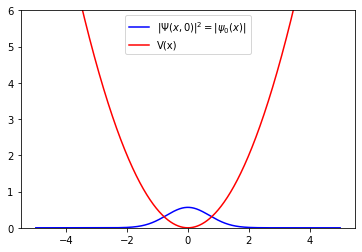

In [5]:
# Teste de funcionamento (okay!)

L = 5 # tamanho do sistema
dt = 0.0001 # passo temporal
r = 1 # parâmetro auxiliar
x_plot, dx = cria_vetor_espacial(L, r, dt) # vetor espacial

m = h_bar = 1 # constantes principais
omega = 1 # frequência de oscilação
n = 0 # auto-funcao inicial

psi_t0_plot = auto_funcao(n,x_plot)
V_plot = potencial_V(x_plot)

plt.plot(x_plot, np.abs(psi_t0_plot)**2, color='blue', label=r'$|\Psi(x,0)|^2 = |\psi_0(x)|$')
plt.ylim(0,6)
plt.legend()
#plt.show()

#print()

plt.plot(x_plot, V_plot, color='red', label='V(x)')
plt.legend()
#plt.show()


### 1) Resolve a equação de Schrodinger completa

In [6]:
# Função que define o range temporal do problema

def cria_vetor_temporal(tf, dt):
  # Parâmetros de entrada
    # - tf: tempo final da simulação
    # - dt: intervalo de tempo entre os pontos do vetor
  # Valores de saída
    # - Vetor com os valores de tempo indo de 0 a tf, igualmente espaçados por dt
  
  # ----------------------------------------------------------------------------------------
  return np.arange(0, tf+dt, dt)

In [7]:
# Função que soluciona numericamente a equação de Schrodinger completa com base no
# método RK-2 (Runge-Kutta de ordem 2)

def resolve_Schrodinger(x, t, cond_initi):
  # Parâmetros de entrada:
    # - Psi_t0: função que caracteriza a função de onda no instante t = 0
    # - V: função potencial 
    # - tf: instante final da simulação
    # - dt: passo temporal
    # - r: parâmetro numérico auxiliar (definição de dt e dx)

  # Valores de saída
    # - Psi: matriz Psi(x,t) representando a função de onda em cada ponto para todos
    # os instantes de tempo definidos no problema
    # - N: vetor de normalização para todos os instantes de tempo

  # !ATENÇÃO!
  # As constantes omega e n (presentes, nesse estudo em questão, nas funções responsáveis
  # por determinar o potencial e a condição inicial em cada ponto) devem ser definidas
  # como variáveis globais, bem como as constantes m e h_bar.
  # ----------------------------------------------------------------------------------------

  xsize = len(x) # tamanho do vetor espacial
  tsize = len(t) # tamanho do vetor temporal

  R = np.zeros( (xsize,tsize) ) # parte real da Psi
  I = np.zeros( (xsize,tsize) ) # parte complexa da Psi
  Psi = np.zeros( (xsize,tsize), dtype='complex' ) # matriz Psi(x,t)
  V = potencial_V(x) # potencial em cada ponto 
  meio = np.zeros( (2,xsize) ) # matriz auxiliar para guardar os meios passos
  N = np.zeros(tsize) # vetor para guardar a integral de normalização em cada instante

  # aplica a condição inicial
  Psi[:,0] = cond_initi

  # corrige as condições de contorno
  Psi[xsize-1,:] = 0 
  Psi[0,:] = 0 

  # aplica a cond inicial, com conds contorno ja ajustadas, na parte real e na parte imaginária
  R[:,0] = np.real(Psi[:,0])
  I[:,0] = np.imag(Psi[:,0])

  # -- x -- x -- x -- x -- x -- x -- x -- x -- x -- x -- x -- x -- x -- x --

  # Funções auxiliares necessárias ao desenvolvimento do método RK2
  def calcula_k_I(r, dt, R_right, R_here, R_left, V_here):
    return r*(R_right - 2*R_here + R_left) - V_here*R_here*dt
  
  def calcula_k_R(r, dt, I_right, I_here, I_left, V_here):
    return -r*(I_right -2*I_here + I_left) + V_here*I_here*dt

  # -- x -- x -- x -- x -- x -- x -- x -- x -- x -- x -- x -- x -- x -- x --

  # inicia o loop de aplicação do método RK-2 atualizando R(i,n) e I(i,n)

  for n in range(tsize-1): # para cada instante de tempo
    for i in range(xsize-1): # para cada posição 
      # calcula k1_R, k2_I e os valores a meio-passo
      k1_R = calcula_k_R(r, dt, I[i+1][n], I[i][n], I[i-1][n], V[i]) # k1 é calculado para as variáveis agora (n atual)
      k1_I = calcula_k_I(r, dt, R[i+1][n], R[i][n], R[i-1][n], V[i]) # k1 é calculado para as variáveis agora (n atual)
    
      # calcula as variáveis a meio passo
      R_12_passo = R[i][n] + k1_R/2
      I_12_passo = I[i][n] + k1_I/2

      # atualiza na matriz meio-passo
      meio[0][i] = R_12_passo # joga o R para a primeira linha 
      meio[1][i] = I_12_passo # joga o I para a segunda linha 
    
    # calcula R_12_passo e I_12_passo para o último elemento (não englobado no loop anterior)
    k1_R = calcula_k_R(r, dt, 0, I[xsize-1][n], I[xsize-2][n], V[xsize-1]) # I[(xsize-1) + 1][n] = 0 (condição de contorno)
    k1_I = calcula_k_I(r, dt, 0, R[xsize-1][n], R[xsize-2][n], V[xsize-1]) # R[(xsize-1) + 1][n] = 0 (condição de contorno)

    ultimo_R_12_passo = R[xsize-1][n] + k1_R/2
    ultimo_I_12_passo = I[xsize-1][n] + k1_I/2

    # acrescenta na matriz
    meio[0][xsize-1] = ultimo_R_12_passo
    meio[1][xsize-1] = ultimo_I_12_passo

    # loop para atualizar a função psi
    for i in range(1,xsize-1): # de 1 até xsize-1 porque as bordas têm que estar sempre em 0 (cond contorno)
      # calcula k2_R e k2_I
      k2_R = calcula_k_R(r, dt, meio[1][i+1], meio[1][i], meio[1][i-1], V[i]) # k2_R é calculado com o I_12_passo, já atualizado para todas as posições na matriz 'meio'
      k2_I = calcula_k_I(r, dt, meio[0][i+1], meio[0][i], meio[0][i-1], V[i]) # k2_I é calculado com o R_12_passo, já atualizado para todas as posições na matriz 'meio'

      # atualiza os vetores R e I
      R[i][n+1] = R[i][n] + k2_R
      I[i][n+1] = I[i][n] + k2_I

      # atualiza a matriz psi
      Psi[i][n+1] = R[i][n+1] + 1j*I[i][n+1]
    
    # uma vez atualizadas as variáveis no instante n, verifica a normalização e atualiza no vetor N
    N[n] = np.sum(np.abs(Psi[:,n])**2)*dx

  # calcula a última norma separadamente
  N[tsize-1] = np.sum(np.abs(Psi[:,tsize-1])**2)*dx

  return Psi, N

In [8]:
# teste de funcionamento (okay!)

m = h_bar = 1 # constantes principais ajustadas a 1
omega = 50 # frequência angular de oscilação do sistema
n = 1 # ordem do auto-estado de energia de interesse
tf = 0.05 # tempo final da simulação
dt = 0.0001 # passo temporal
r = 0.075 # parâmetro numérico auxiliar
L = 1 # 'tamanho' espacial do sistema

x, dx = cria_vetor_espacial(L, r, dt)
Psi_t0 = auto_funcao(n, x)

t = cria_vetor_temporal(tf, dt)
Psi, N = resolve_Schrodinger(x, t, Psi_t0)

xsize = len(x)
for i in range(10):
    print("{:10.6e}".format( Psi[xsize//2+i,-1]) )
for j in range(-10,0):
    print("{:10.6e}".format( N[j]) )



-1.149114e-01+8.007134e-02j
-5.264741e-01+3.666787e-01j
-8.867497e-01+6.169382e-01j
-1.164109e+00+8.085592e-01j
-1.339737e+00+9.284834e-01j
-1.409433e+00+9.741176e-01j
-1.382510e+00+9.524574e-01j
-1.278388e+00+8.775532e-01j
-1.121926e+00+7.671147e-01j
-9.386854e-01+6.391240e-01j
1.000000e+00
1.000000e+00
1.000000e+00
1.000000e+00
1.000000e+00
1.000000e+00
1.000000e+00
1.000000e+00
1.000000e+00
1.000000e+00


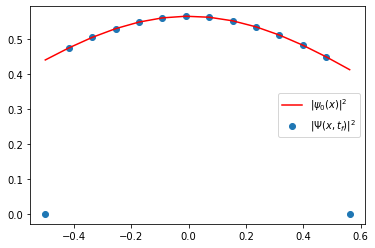

In [9]:
# comparação da função |Psi(x,t)|^2 obtida pela simulação com a função |Psi(x,t)|^2 analítica
# (solução analítica da eq de Schrodinger) para o estado de energia n = 0.

m = h_bar = 1 # constantes principais ajustadas a 1
omega = 1 # frequência angular de oscilação do sistema
n = 0 # ordem do auto-estado de energia de interesse
tf = 0.5 # tempo final da simulação
dt = 0.001 # passo temporal
r = 0.075 # parâmetro numérico auxiliar
L = 0.5 # 'tamanho' espacial do sistema

x, dx = cria_vetor_espacial(L, r, dt)
Psi_t0 = auto_funcao(n, x)
Psi, N= resolve_Schrodinger(x, t, Psi_t0)

xsize = len(x)
tsize = len(t)

plt.scatter(x, np.abs(Psi[:,0])**2, label=r'$| \Psi(x,t_f)|^2$')
plt.plot(x, np.abs(auto_funcao(n,x))**2, label=r'$|\psi_0(x)|^2$', color='red')
plt.legend()
plt.show()

#plt.scatter(t, N)
#plt.ylim(0,6)

- A escolha dos parâmetros de simulação (em especial, L) não foi feita corretamente)

### 2) Calcula <E\> (t)

In [10]:
# Função que toma a função de onda Psi(x,t), os vetores espacial e temporal,
# e retorna o valor esperado da energia 
def valor_esperado_E(Psi, N, x, dx, t):
  # Parâmetros de entrada:
    # - Psi: matriz Psi(x,t) contendo a função de onda para todas as posições e todos os instantes de tempo
    # - N: vetor de normalização da simulação efetuada
    # - x: vetor espacial do sistema simulado
    # - dx: passo espacial
    # - t: vetor temporal do sistema simulado
    # - potencial: função potencial

  # Valores de saída:
    # - esp_E: vetor contendo o valor esperado da energia para cada instante de tempo
  # ----------------------------------------------------------------------------------------

  xsize = len(x) # tamanho do vetor espacial
  tsize = len(t) # tamanho do vetor temporal

  R = np.real(Psi) # parte real da função de onda
  I = np.imag(Psi) # parte imaginária da função de onda
  V = potencial_V(x) # potencial em cada ponto
  HR = np.zeros(xsize) # hamiltoniano aplicado à parte real
  HI = np.zeros(xsize) # hamiltoniano aplicado à parte imaginaria
  HPsi = np.zeros( (xsize, tsize) ) # hamiltoniano aplicado à função de onda completa Psi
  esp_E = np.zeros(tsize) # vetor para guardar o cálculo de <E> a cada instante de tempo

  for n in range(tsize): # para cada instante de tempo
    # não é preciso resetar os vetores HI e HR a cada volta do loop;
    # eles terão seus valores atualizados normalmente para cada instante de tempo

    # calcula o termo 0 separadamente de cada hamiltoniano
    HR[0] = -(1/2)*(R[1][n] - 2*R[0][n])/dx**2 + V[0]*R[0][n] # derivada 2ª simétrica (nesse caso o termo[i-1] = 0)
    HI[0] = -(1/2)*(I[1][n] - 2*I[0][n])/dx**2 + V[0]*I[0][n] # derivadas 2ª simétrica (nesse caso o termo[i-1] = 0)

    for i in range(1,xsize-1): # para cada posição 
      HR[i] = -(1/2)*(R[i+1][n] - 2*R[i][n] + R[i-1][n])/dx**2 + V[i]*R[i][n]
      HI[i] = -(1/2)*(I[i+1][n] - 2*I[i][n] + I[i-1][n])/dx**2 + V[i]*I[i][n]
    
    # calcula o ultimo termo separadamente de cada hamiltoniano
    HR[xsize-1] = -(1/2)*(R[xsize-1][n] - 2*R[xsize-2][n])/dx**2 + V[xsize-1]*R[xsize-1][n] # derivada 2ª simétrica (nesse caso o termo[i+1] = 0)
    HI[xsize-1] = -(1/2)*(I[xsize-1][n] - 2*I[xsize-2][n])/dx**2 + V[xsize-1]*I[xsize-1][n] # derivada 2ª simétrica (nesse caso o termo[i+1] = 0)

    # define HPsi
    HPsi = HR + 1j*HI

    # calcula o valor esperado da energia no instante de tempo n
    esp_E[n] = np.real(np.trapz( np.conjugate(Psi[:,n])*HPsi , dx = dx))/N[n]
  
  return esp_E

(45.0, 55.0)

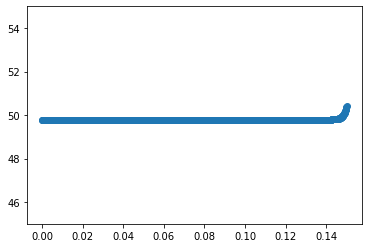

In [19]:
# teste de funcionamento (okay)
m = h_bar = 1
omega = 100 
n = 0
tf = 0.05 
dt = 0.0001
L = 1
r = 0.075

#x, dx = cria_vetor_espacial(L, r, dt)
#plt.plot(x, potencial_V(x))

x, dx = cria_vetor_espacial(L, r, dt)
Psi_t0 = auto_funcao(n, x)
Psi, N = resolve_Schrodinger(x, t, Psi_t0)

esp_E = valor_esperado_E(Psi, N, x, dx, t)
#print(dx)
#plt.axhline(y = 25, color='red')
plt.scatter(t, esp_E)
plt.ylim(45,55)


### 3) Calcula <x\>(t)

In [12]:
def valor_esperado_x(Psi, N, x, dx, t):
  # Parâmetros de entrada:
    # - Psi: matriz Psi(x,t) contendo a função de onda para todas as posições e todos os instantes de tempo
    # - N: vetor de normalização da simulação efetuada
    # - x: vetor espacial do sistema simulado
    # - dx: passo espacial
    # - t: vetor temporal do sistema simulado
    # - potencial: função potencial

  # Valores de saída:
    # - esp_E: vetor contendo o valor esperado da energia para cada instante de tempo
  # ----------------------------------------------------------------------------------------

  xsize = len(x) # tamanho do vetor espacial
  tsize = len(t) # tamanho do vetor temporal

  R = np.real(Psi) # parte real da função de onda
  I = np.imag(Psi) # parte imaginária da função de onda
  V = potencial_V(x) # potencial em cada ponto
  esp_x = np.zeros(tsize) # vetor para guardar o cálculo de <E> a cada instante de tempo

  for n in range(tsize): # para cada instante de tempo
    # calcula o valor esperado da posição no instante de tempo n
    esp_x[n] = np.trapz(x*np.abs(Psi[:,n])**2, dx=dx)/N[n]
  
  return esp_x

(-0.1, 0.1)

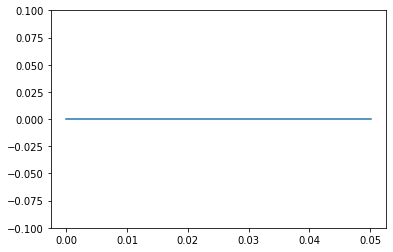

In [13]:
# teste de funcionamento (okay!)
m = h_bar = 1
omega = 100
n = 10 # => analiticamente que <x>(t) = 0
tf = 0.05
dt = 0.0001
L = 1
r = 0.075

x, dx = cria_vetor_espacial(L, r, dt)
t = cria_vetor_temporal(tf, dt)

Psi_t0 = auto_funcao(n , x)

Psi, N = resolve_Schrodinger(x, t, Psi_t0)
esp_x = valor_esperado_x(Psi, N, x, dx, t)
plt.plot(t, esp_x)
plt.ylim(-0.1,0.1)

### 4) Cria gif que mostra a evolução temporal de Psi(x,t)

In [14]:
# Função para criar um gif mostrando a 'evolução temporal' da 
# função de onda de um determinado sistema

def cria_gif(Psi, x, t, Name):
  # -------------------------------------------------------------------------
  # Parâmetros de entrada
    # - Psi: matriz Psi caracterizando a função de onda da simulação efetuada
    # - x: vetor espacial
    # - t: vetor temporal

  # Valores de saída:
    # - Gif de evolução do sistema a cada instante de tempo
  # -------------------------------------------------------------------------
  tsize = len(t)
  filenames = [] # vetor auxiliar para guardar o nome das figuras que compõem cada frame do gif
  
  max = 0 # quantidade auxiliar para o plot
  for i in range(len(t)):
    if np.max(np.real(Psi[:,i])) >= max:
      max = np.max(np.real(Psi[:,i]))
    elif np.max(np.imag(Psi[:,i])) > max:
      max = np.max(np.imag(Psi[:,i]))

  !mkdir pasta_frames # crio um diretório dentro do colab para guardar as figuras de cada frame
  for a in range(tsize): # para cada frame
    # Constrói a figura a ser apresentada 
    ax = plt.figure(figsize=(9,6))
    ax = plt.plot(x, np.real(Psi[:,a]), label = r'$\mathcal{R}[\Psi(x,t)]$') # parte real
    ax = plt.plot(x, np.imag(Psi[:, a]), label = r'$\mathcal{I}[\Psi(x,t)]$') # parte imagnária

    plt.ylim(-max, max)

    plt.title('Evolução temporal da função de onda $\Psi(x,t)$', fontsize=22)
    plt.xlabel(r'$x \, [u.c.]$', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=16)

    # construção dos frames do gif
    filename = 'frame_{}.png'.format(a)
    filenames.append(filename)

    if a == tsize-1: # se estiver no último frame do gif 
      for k in range(5):
        filenames.append(filename) # acrescenta uma pausa maior (em todos os frames)

    plt.savefig('pasta_frames/{}'.format(filename)) # salvo as figuras dentro do diretório criado
    plt.close()

  # Cria o gif 
  with imageio.get_writer('{}.gif'.format(Name), mode='I') as writer:
    for filename in filenames:
      image = imageio.imread('pasta_frames/{}'.format(filename))
      writer.append_data(image)
  
  !rm -rf pasta_frames # deleto o diretório de figuras criado


In [20]:
# teste de funcionamento
m = h_bar = 1 
omega = 100
n = 1 
L = 1
tf = 0.05
dt = 1e-4
r = 0.075
k0 = 5

x, dx = cria_vetor_espacial(L, r, dt)
t = cria_vetor_temporal(tf, dt)
Psi_t0 = auto_funcao(n, x)*np.exp(1j*k0*x)

Psi, N = resolve_Schrodinger(x, t, Psi_t0)
#for i in range(0, len(t[:200]),50):
  #plt.plot(x,np.real(Psi[:,i]), label='t = {}'.format(i))
#  plt.plot(x,np.imag(Psi[:,i]), label='t = {}'.format(i))
#plt.legend()
#cria_gif(Psi, x, t, 'teste1')

## Códigos de Análise / Relatório

 #### Plot auxiliar para ilustrar a função potencial de um sistema genérico e os respectivos mínimos

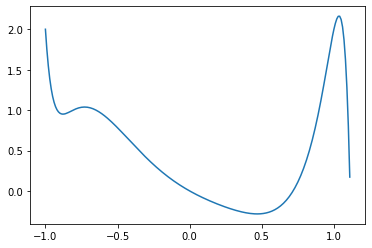

Pontos de mínimo local: -0.87839,0.46825


In [17]:
from scipy.optimize import fsolve

def aux(x): # polinômio genérico
  return x**2-x**3+3*x**5-x+x**16-x**21 

def d_aux(x): # primeira derivada
  return 2*x-3*x**2+15*x**4-1+16*x**15-21*x**20 

def d2_aux(x): # segunda derivada
  return 2-6*x+60*x**3+96*x**14-420*x**19

x = np.arange(-1,1.12, 0.01)
plt.plot(x, aux(x))
plt.show()

pontos_criticos = fsolve(d_aux, [-1,-0.5,0.5,1]) # obenção dos máximos / mínimos locais
x01 = pontos_criticos[0] # primeiro ponto de mínimo (local)
x02 = pontos_criticos[2] # segundo ponto de mínimo (local)
print('Pontos de mínimo local: {:.5f},{:.5f}'.format(x01, x02))

In [18]:
def aprox_Taylor1(x):
  return aux(x01) + (1/2)*d2_aux(x01)*(x-x01)**2

def aprox_Taylor2(x):
  return aux(x02) + (1/2)*d2_aux(x02)*(x-x02)**2

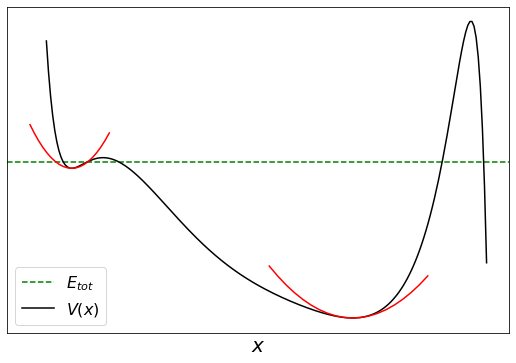

In [19]:
ax = plt.figure(figsize=(9,6))
plt.xlabel(r'$x$', fontsize=20) 

x = np.arange(-1,1.12, 0.01)
ax = plt.axhline(1, color='green', linestyle='dashed', label=r'$E_{tot}$')
ax = plt.plot(x, aux(x), color='black', label=r'$V(x)$')

eps1 = 0.2
eps2 = 0.4
x01_plot = np.arange(x01-eps1, x01+eps1, eps1/10)
x02_plot = np.arange(x02-eps2, x02+eps2, eps2/10)

ax = plt.plot(x01_plot, aprox_Taylor1(x01_plot), color='red')
ax = plt.plot(x02_plot, aprox_Taylor2(x02_plot), color='red')

plt.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

plt.legend(fontsize=16)

#### Manual do código e análise da melhor escolha dos parâmetros de simulação (tf, L, dt, r)

- Há um problema associado ao *tamanho do sistema* 
  - Frequências baixas => a função potencial demora para apresentar uma influência relevante (i.e., demora pra crescer), então é necessário utilizar um sistema de simulação grande para identificar as oscilações da partícula do oscilador => os valores esperados são calculados corretamente e a função de onda numérica obtida tem consistência física
  - Frequências altas => a função potencial cresce muito rapidamente, então escolher um sistema pequeno já é suficiente para avaliar as oscilações da partícula corretamente => os valores esperados são calculados corretamente e a função de onda numérica obtida tem consistência física

In [20]:
# !Definição das variáveis globais!
m = h_bar = 1 # constantes principais em [u.c.]
omega = 100 # frequência de oscilação

L = 1 # tamanho espacial do sistema
tf = 0.05 # tempo final da simulação 
r = 0.075 # parâmetro numérico auxiliar
dt = 0.0001 # passo temporal
n = 0 # auto-estado de energia

# ----------------------------------------------------------------------------

x, dx = cria_vetor_espacial(L, r, dt) # define espaço do sistema
t = cria_vetor_temporal(tf, dt) # define o intervalo temporal da simulação

Psi_t0 = auto_funcao(n, x) # define a condição inicial
Psi, N = resolve_Schrodinger(x, t, Psi_t0) # efetua a simulação numérica do sistema

esp_E = valor_esperado_E(Psi, N, x, dx, t) # obtém o valor esperado da energia
esp_x = valor_esperado_x(Psi, N, x, dx, t) # obtém o valor esperado da posição

cria_gif(Psi, x, t, 'exemplo_manual') # cria um gif de evolução temporal da função de onda

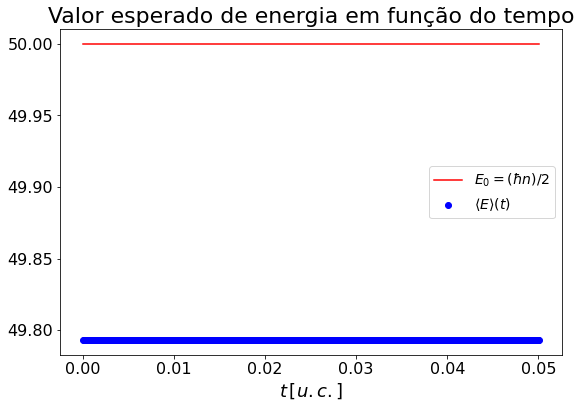

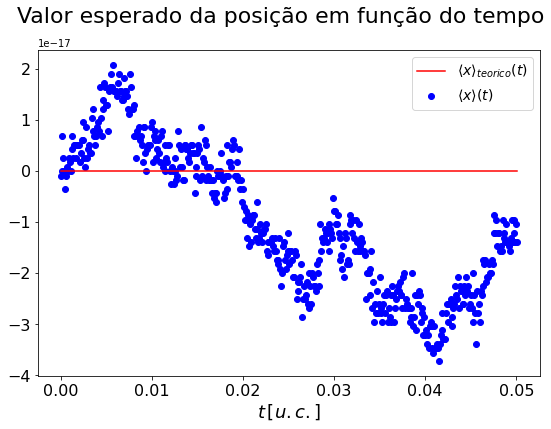

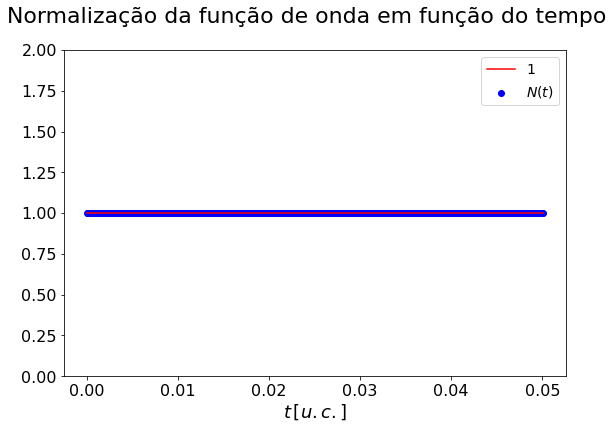

In [21]:
# Plots de esp_E, esp_x e N

# Plot de esp_E
plt.figure(figsize=(9,6))

plt.scatter(t, esp_E, color='blue', label=r'$\langle E \rangle(t)$')
plt.plot(t, np.array([50]*len(t)), color='red', label=r'$E_0 = (\hbar n)/2$')

plt.title('Valor esperado de energia em função do tempo', fontsize=22)
plt.yticks(fontsize=16)
plt.xlabel(r'$t \, [u.c.]$', fontsize=18)
plt.xticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()

print()

# ---------------------------------------------------------
# Plot de esp_x
plt.figure(figsize=(9,6))

plt.scatter(t, esp_x, color='blue', label=r'$\langle x \rangle(t)$')
plt.plot(t, np.array([0]*len(t)), color='red', label=r'$\langle x \rangle_{teorico}(t)$')

plt.suptitle('Valor esperado da posição em função do tempo', fontsize=22)
plt.yticks(fontsize=16)
plt.xlabel(r'$t \, [u.c.]$', fontsize=18)
plt.xticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()

print()

# ---------------------------------------------------------
# Plot de N
plt.figure(figsize=(9,6))

plt.scatter(t, N, color='blue', label=r'$N(t)$')
plt.plot(t, np.array([1]*len(t)), color='red', label=r'$1$')

plt.suptitle('Normalização da função de onda em função do tempo', fontsize=22)
plt.yticks(fontsize=16)
plt.xlabel(r'$t \, [u.c.]$', fontsize=18)
plt.xticks(fontsize=16)
plt.legend(fontsize=14)
plt.ylim(0,2)
plt.show()


- Apresentação de problemas e escolha de parâmetros

In [22]:
# Omega = 1 // L = 0.05

m = h_bar = 1 # constantes principais
omega = 1 # frequência do sistema

#L = 0.5 # (escolha problemática)
L = 5 # escolha adequada
tf = 0.05 # tempo total de simulação
dt = 0.0001 # passo temporal
r = 0.075 # parâmetro auxiliar
n = 0 # número da auto-função inicial

x, dx = cria_vetor_espacial(L, r, dt) # cria vetor espacial
t = cria_vetor_temporal(tf, dt) # cria vetor temporal
Psi_t0 = auto_funcao(n, x) # define a condição inicial

Psi, N = resolve_Schrodinger(x, t, Psi_t0) # simula a função de onda
esp_E = valor_esperado_E(Psi, N, x, dx, t) # calcula o valor esperado de E

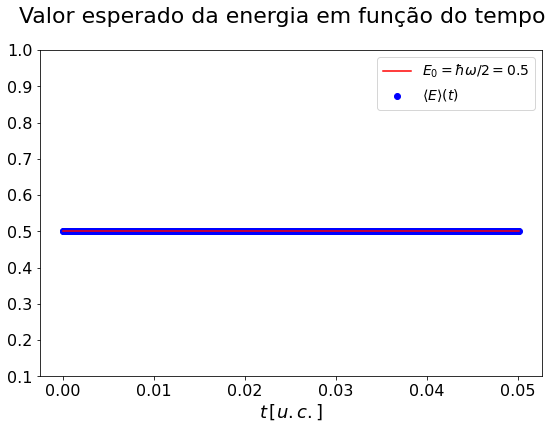

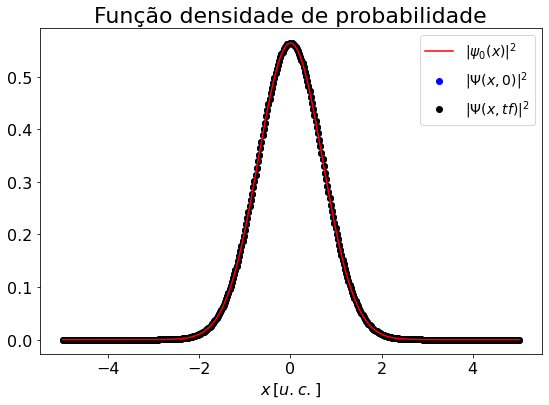

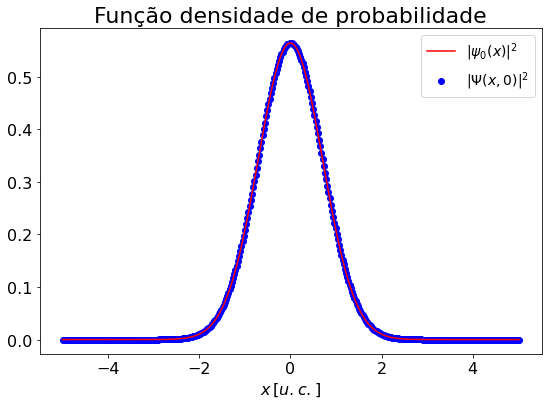

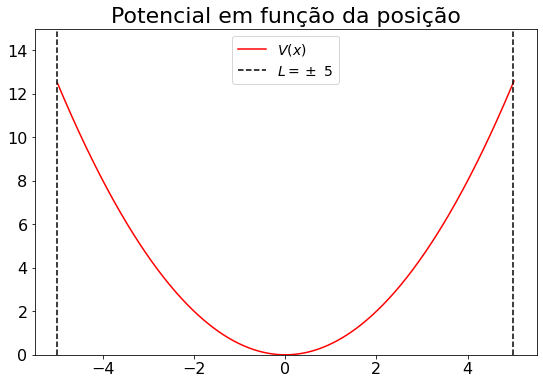

In [23]:
# Valor esperado da energia
plt.figure(figsize=(9,6))

plt.scatter(t, esp_E, color='blue', label=r'$\langle E \rangle(t)$')
plt.plot(t, np.array([1/2]*len(t)), color='red', label=r'$E_0 = \hbar \omega / 2 = 0.5$')

plt.suptitle('Valor esperado da energia em função do tempo', fontsize=22)
plt.yticks(fontsize=16)
plt.xlabel(r'$t \, [u.c.]$', fontsize=18)
plt.xticks(fontsize=16)
plt.legend(fontsize=14)
plt.ylim(0.1,1)
plt.show()
print()

# Comparação da densidade de probabilidade para diferentes instantes de tempo
plt.figure(figsize=(9,6))

plt.plot(x, np.abs(Psi_t0)**2, color='red', linestyle='solid', label=r'$|\psi_0(x)|^2$')
plt.scatter(x, np.abs(Psi[:,0])**2, color='blue', label=r'$|\Psi(x,0)|^2$')
#plt.scatter(x, np.abs(Psi[:,10])**2, color='green', label=r'$|\Psi(x,2)|^2$')
plt.scatter(x, np.abs(Psi[:,len(t)-1])**2, color='black', label=r'$|\Psi(x,tf)|^2$')

plt.title('Função densidade de probabilidade', fontsize=22)
plt.xlabel(r'$x \, [u.c.]$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()
print()

# Apresentação explítica da condição de contorno problemática para a escolha de L pequeno
plt.figure(figsize=(9,6))

plt.plot(x, np.abs(Psi_t0)**2, color='red', linestyle='solid', label=r'$|\psi_0(x)|^2$')
plt.scatter(x, np.abs(Psi[:,0])**2, color='blue', label=r'$|\Psi(x,0)|^2$')

plt.title('Função densidade de probabilidade', fontsize=22)
plt.xlabel(r'$x \, [u.c.]$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()
print()


# Potencial para omega = 1 e L = 0.05
plt.figure(figsize=(9,6))
plt.plot(x, potencial_V(x), color='red', label=r'$V(x)$')
plt.title('Potencial em função da posição', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.axvline(-L, color='black', linestyle='dashed')
plt.axvline(+L, color='black', linestyle='dashed', label=r'$L = \pm$ {}'.format(L))
plt.ylim(0,15)
plt.legend(fontsize=14, loc='upper center')
plt.show()

In [ ]:
# Sobre as escolhas de r e dt
from time import time 

m = h_bar = 1 # constantes principais
omega = 100 # frequência de oscilação  
n = 0 # auto-função inicial
L = 1 # tamanho do sistema
tf = 0.05 # tempo total de simulação
r = 0.075 # mantendo r fixo
dt_aux = [0.1, 0.01, 0.001, 0.0001, 0.00001] # passos temporais


for dt in dt_aux:
  x, dx = cria_vetor_espacial(L, r, dt)
  t = cria_vetor_temporal(tf, dt)
  Psi_t0 = auto_funcao(n, x)

  start = time()
  Psi, N = resolve_Schrodinger(x, t, Psi_t0)
  esp_E = valor_esperado_E(Psi, N, x, dx, t)
  print('dt = {} || dx = {:.5f} || TEMPO DE SIMULAÇÃO: {:.5f}'.format(dt, dx, time()-start))

dt = 0.1 || dx = 0.81650 || TEMPO DE SIMULAÇÃO: 0.00036
dt = 0.01 || dx = 0.25820 || TEMPO DE SIMULAÇÃO: 0.00174
dt = 0.001 || dx = 0.08165 || TEMPO DE SIMULAÇÃO: 0.08368
dt = 0.0001 || dx = 0.02582 || TEMPO DE SIMULAÇÃO: 1.89390
dt = 1e-05 || dx = 0.00816 || TEMPO DE SIMULAÇÃO: 22.76264


### Análise dos valores esperados de energia

In [ ]:
# Simulação para diferentes valores de n e construção de uma tabela

m = h_bar = 1 # constantes principais
r = 0.075 # parâmetro auxiliar
tf = 0.05 # tempo total de simulação
dt = 1e-4 # passo temporal
omega = 100 # frequência de oscilação
L = 1 # tamanho do sistema

n_aux = [0, 1, 2, 3, 4, 5, 6, 7 ,8, 9] # vetor auxiliar de valores de n

for n in n_aux:
  x, dx = cria_vetor_espacial(L, r, dt)
  t = cria_vetor_temporal(tf, dt)
  Psi_t0 = auto_funcao(n, x)

  Psi, N = resolve_Schrodinger(x, t, Psi_t0)
  esp_E = valor_esperado_E(Psi, N, x, dx, t)

  print('n = {} | E_n = {} | <E> (t=0) = {:.3f} | Erro_Perc = {:.3f} %'.format(n, omega*(n+1/2), esp_E[0], 100*np.abs(esp_E[0] - omega*(n+1/2))/(omega*(n+1/2)) ))
  

n = 0 | E_n = 50.0 | <E> (t=0) = 49.793 | Erro_Perc = 0.414 %
n = 1 | E_n = 150.0 | <E> (t=0) = 148.966 | Erro_Perc = 0.689 %
n = 2 | E_n = 250.0 | <E> (t=0) = 247.320 | Erro_Perc = 1.072 %
n = 3 | E_n = 350.0 | <E> (t=0) = 344.864 | Erro_Perc = 1.467 %
n = 4 | E_n = 450.0 | <E> (t=0) = 441.606 | Erro_Perc = 1.865 %
n = 5 | E_n = 550.0 | <E> (t=0) = 537.556 | Erro_Perc = 2.263 %
n = 6 | E_n = 650.0 | <E> (t=0) = 632.722 | Erro_Perc = 2.658 %
n = 7 | E_n = 750.0 | <E> (t=0) = 727.113 | Erro_Perc = 3.052 %
n = 8 | E_n = 850.0 | <E> (t=0) = 820.738 | Erro_Perc = 3.443 %
n = 9 | E_n = 950.0 | <E> (t=0) = 913.606 | Erro_Perc = 3.831 %


In [ ]:
# Observo que o erro percentual aumenta à medida que o n aumenta
# Justificativa: isso acontece pq n maior => estados mais energéticos => mais oscilações
# => precisamos de um passo temporal menor pra ganhar mais precisão 
# (como dt e dx estao vinculados, dt menor => dx menor, então tbm ganhamos mais precisão espacial
# na função de onda e, consequentemente, as integrais em x para o cálculo de <E> fica melhor)

# Nova simulação para os mesmos valores de n, mas para uma precisão maior do passo dt

m = h_bar = 1 # constantes principais
r = 0.075 # parâmetro auxiliar
dt = 1e-5 # passo temporal
tf = 0.05 # tempo total de simulação 
omega = 100 # frequência de oscilação
L = 1 # tamanho do sistema

n_aux = [0, 1, 2, 3, 4, 5, 6, 7 ,8, 9] # vetor auxiliar de valores n

for n in n_aux:
  x, dx = cria_vetor_espacial(L, r, dt)
  t = cria_vetor_temporal(tf, dt)
  Psi_t0 = auto_funcao(n, x)

  Psi, N = resolve_Schrodinger(x, t, Psi_t0)
  esp_E = valor_esperado_E(Psi, N, x, dx, t)

  print('n = {} | E_n = {} | <E> (t=0) = {:.3f} | Erro_Perc = {:.3f} %'.format(n, omega*(n+1/2), esp_E[0], 100*np.abs(esp_E[0] - omega*(n+1/2))/(omega*(n+1/2)) ))
  

n = 0 | E_n = 50.0 | <E> (t=0) = 49.97918 | Erro_Perc = 0.04164 %
n = 1 | E_n = 150.0 | <E> (t=0) = 149.89591 | Erro_Perc = 0.06939 %
n = 2 | E_n = 250.0 | <E> (t=0) = 249.72946 | Erro_Perc = 0.10822 %
n = 3 | E_n = 350.0 | <E> (t=0) = 349.47990 | Erro_Perc = 0.14860 %
n = 4 | E_n = 450.0 | <E> (t=0) = 449.14732 | Erro_Perc = 0.18948 %
n = 5 | E_n = 550.0 | <E> (t=0) = 548.73184 | Erro_Perc = 0.23058 %
n = 6 | E_n = 650.0 | <E> (t=0) = 648.23352 | Erro_Perc = 0.27177 %
n = 7 | E_n = 750.0 | <E> (t=0) = 747.65248 | Erro_Perc = 0.31300 %
n = 8 | E_n = 850.0 | <E> (t=0) = 846.98879 | Erro_Perc = 0.35426 %
n = 9 | E_n = 950.0 | <E> (t=0) = 946.24255 | Erro_Perc = 0.39552 %


- Análise da novo estado inicial

$$ \Psi(x, t=0) = \psi_0(x)e^{ik_0x}$$ 

como $k_0$ impacta o valor esperado de energia e o valor esperado da posição?

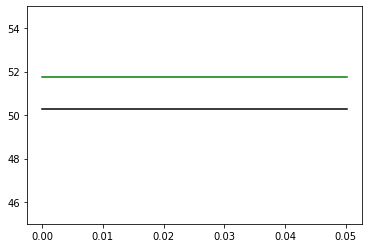

In [ ]:

m = h_bar = 1 
omega = 100
dt = 1e-4
L = 1 
tf = 0.05
r = 0.075
n = 0

x, dx = cria_vetor_espacial(L, r, dt)
t = cria_vetor_temporal(tf, dt)

k01 = 1
Psi_t01 = auto_funcao(n, x)*np.exp(1j*k01*x)
Psi, N = resolve_Schrodinger(x, t, Psi_t01)

esp_E1 = valor_esperado_E(Psi, N, x, dx, t)
plt.plot(t, esp_E1, color='black', label='k0 = 1')

k02 = 2
Psi_t02 = auto_funcao(n, x)*np.exp(1j*k02*x)
Psi, N = resolve_Schrodinger(x, t, Psi_t02)
esp_E2 = valor_esperado_E(Psi, N, x, dx, t)
plt.plot(t, esp_E2, color='green', label='k0 = 2')

plt.ylim(45,55)
plt.show()


In [ ]:
# Simulação para cálculo dos valores esperados de E para diferentes valores de n,
# mas agora levando em conta a presença da exponencial complexa exp(ik0x)

m = h_bar = 1 # constantes principais
r = 0.075 # parâmetro auxiliar
dt = 1e-5 # passo temporal
tf = 0.05 # tempo de simulação
omega = 100 # frequência de oscilação
L = 1 # tamanho do sistema

n_aux = [0, 1, 2, 3, 4, 5, 6, 7 ,8, 9] # vetor auxiliar
k0 = 5 # valor escolhido para k0

for n in n_aux: # para cada n no vetor n_aux
  x, dx = cria_vetor_espacial(L, r, dt) # cria um vetor espacial
  t = cria_vetor_temporal(tf, dt) # cria um vetor temporal

  # Simulação 1)
  # ---------------------------------------------------------------------------------
  Psi_t0 = auto_funcao(n, x) # condição inicial sem perturbação exponencial

  Psi, N = resolve_Schrodinger(x, t, Psi_t0) # simula o sistema
  esp_E1 = valor_esperado_E(Psi, N, x, dx, t) # calcula os valores esperados de energia
  # ---------------------------------------------------------------------------------

  # Simulação 2)
  # ---------------------------------------------------------------------------------
  Psi_t0 = auto_funcao(n,x)*np.exp(1j*k0*x) # concição inicial com perturbação exponencial
  
  Psi,N = resolve_Schrodinger(x, t, Psi_t0) # simula o sistema
  esp_E2 = valor_esperado_E(Psi, N, x, dx, t) # calcula os valores esperados de energia

  print("n = {} | <E> = {:.3f} | <E'> (t=0) = {:.3f} | Discrepância = {:.3f}".format(n, esp_E1[0], esp_E2[0], np.abs(esp_E1[0] - esp_E2[0])))
  

n = 0 | <E> = 49.979 | <E'> (t=0) = 62.457 | Discrepância = 12.47745
n = 1 | <E> = 149.896 | <E'> (t=0) = 162.332 | Discrepância = 12.43586
n = 2 | <E> = 249.729 | <E'> (t=0) = 262.124 | Discrepância = 12.39434
n = 3 | <E> = 349.480 | <E'> (t=0) = 361.833 | Discrepância = 12.35288
n = 4 | <E> = 449.147 | <E'> (t=0) = 461.459 | Discrepância = 12.31150
n = 5 | <E> = 548.732 | <E'> (t=0) = 561.002 | Discrepância = 12.27019
n = 6 | <E> = 648.234 | <E'> (t=0) = 660.462 | Discrepância = 12.22894
n = 7 | <E> = 747.652 | <E'> (t=0) = 759.840 | Discrepância = 12.18776
n = 8 | <E> = 846.989 | <E'> (t=0) = 859.135 | Discrepância = 12.14666
n = 9 | <E> = 946.243 | <E'> (t=0) = 958.348 | Discrepância = 12.10562


In [ ]:
# Construção das animações correspondentes às diferentes funções de onda 
# utilizadas para apresentação da tabela anterior

m = h_bar = 1 # constantes principais
r = 0.075 # parâmetro auxiliar
dt = 1e-4 # passo temporal
tf = 0.05 # tempo de simulação
omega = 100 # frequência de oscilação
L = 1 # tamanho do sistema

n_aux = [0, 1, 2, 3, 4, 5, 6, 7 ,8, 9] # vetor auxiliar
k0 = 5 # valor escolhido para k0

for n in n_aux:
  x, dx = cria_vetor_espacial(L, r, dt) # cria um vetor espacial
  t = cria_vetor_temporal(tf, dt) # cria um vetor temporal
  Psi_t0 = auto_funcao(n,x)*np.exp(1j*k0*x) # concição inicial com perturbação exponencial
  
  Psi,N = resolve_Schrodinger(x, t, Psi_t0) # simula o sistema
  cria_gif(Psi, x, t, 'k0 = {} || n = {}'.format(k0, n))


- Teorema de ehrenfest 

$$
\langle p \rangle = m \frac{d \langle x \rangle}{dt}
$$

$$
\frac{d\langle p \rangle}{dt} = \left\langle - \frac{\partial V}{\partial x} \right\rangle
$$



(-1.0, 1.0)

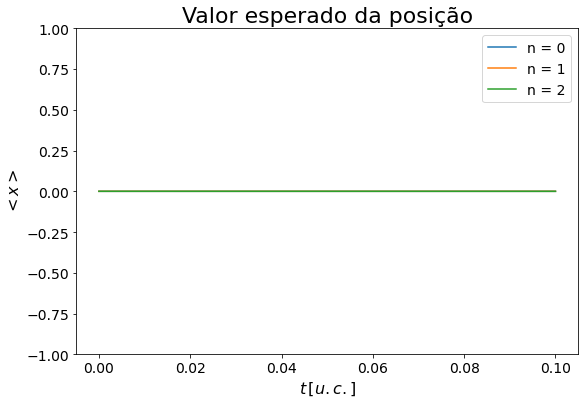

In [ ]:
# Teste para diferentes valores de n na condição inicial e verificação do fato de que 
# <x> = 0

m = hbar = 1 # constantes principais
L = 0.5 # tamanho do sistema
tf = 0.1 # tempo total de simulação (tf > T)
dt = 1e-5 # passo temporal 
r = 0.075 # parâmetro auxiliar
omega = 100 # => T = 2pi/omega ~ 0.06
n_aux = [0,1,2] # número n da auto-função inicial

ax = plt.figure(figsize=(9,6))
for n in n_aux:
  x,dx = cria_vetor_espacial(L, r, dt)
  t = cria_vetor_temporal(tf, dt)
  Psi_t0 = auto_funcao(n, x)

  Psi, N, = resolve_Schrodinger(x, t, Psi_t0)
  esp_x = valor_esperado_x(Psi, N, x, dx, t)
  esp_E = valor_esperado_E(Psi, N, x, dx, t) 

  ax = plt.plot(t, esp_x, label='n = {}'.format(n))
plt.legend(fontsize=14)
plt.title('Valor esperado da posição', fontsize=22)
plt.xlabel(r'$t \, [u.c.]$', fontsize=16)
plt.ylabel(r'$<x>$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-1,1)

In [ ]:
# Teste para diferentes valores de k0

m = hbar = 1 # constantes principais
L = 1 # tamanho do sistema
tf = 0.15 # tempo total de simulação (tf > T)
dt = 1e-4 # passo temporal 
r = 0.075 # parâmetro auxiliar
omega = 100 # => T = 2pi/omega ~ 0.06
n = 0 # número n da auto-função inicial
k0_aux = [1,5,10,20] # vetor de parâmetros k0

ax = plt.figure(figsize=(9,6))
for k0 in k0_aux:
  x,dx = cria_vetor_espacial(L, r, dt)
  t = cria_vetor_temporal(tf, dt)
  Psi_t0 = auto_funcao(n, x)*np.exp(1j*k0*x)

  Psi, N, = resolve_Schrodinger(x, t, Psi_t0)
  cria_gif(Psi, x, t, 'k0 = {} || n = 0'.format(k0))
  esp_x = valor_esperado_x(Psi, N, x, dx, t)
  esp_E = valor_esperado_E(Psi, N, x, dx, t) 

  ax = plt.plot(t, esp_x, label='k0 = {} [u.c.]'.format(k0))
plt.axvline(0.0645, color='black', linestyle='dashed')
plt.legend(fontsize=14)
plt.title('Valor esperado da posição', fontsize=22)
plt.xlabel(r'$t \, [u.c.]$', fontsize=16)
plt.ylabel(r'$<x>$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 0.08) # análise do período de oscilação

In [16]:
# execução da última simulação separadamente por questões de RAM do colab

m = hbar = 1 # constantes principais
L = 1 # tamanho do sistema
tf = 0.15 # tempo total de simulação (tf > T)
dt = 1e-4 # passo temporal 
r = 0.075 # parâmetro auxiliar
omega = 100 # => T = 2pi/omega ~ 0.06
n = 0 # número n da auto-função inicial
k0 = 20 # parâmetro k0

x,dx = cria_vetor_espacial(L, r, dt)
t = cria_vetor_temporal(tf, dt)
Psi_t0 = auto_funcao(n, x)*np.exp(1j*k0*x)

Psi, N, = resolve_Schrodinger(x, t, Psi_t0)
cria_gif(Psi, x, t, 'k0 = {} || n = 0'.format(k0))

mkdir: cannot create directory ‘pasta_frames’: File exists
